In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import qiskit.tools.jupyter # for popup job monitoring

import json
from pathlib import Path

from datetime import datetime

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

import numpy as np

%matplotlib inline
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

# Solution to Final Challenge (Team Whit3z)

For this challenge, the problem assigning konbini to each district is an instance of graph coloring problem with 4 colors. In order to build oracle function (or rather circuit), the main idea is to check whether each edge doesn't connect between two nodes of the same color (konbini chain). In order to reduce the edge check, we infer information about some of the nodes, like cycle checking or how some node cannot be certain konbini chains.

## Idea of Oracle

We'll describe two steps to build oracle by first explaining the base idea and second on how to reduce the check condition.

### Basic Idea

- have one ancilla bit starting as $\left|0\right\rangle$ to represent each edge of the graph; we call this "edge ancilla"
- we'll flip edge ancilla to $\left|1\right\rangle$ if the two nodes connecting to the corresponding edge don't have the same konbini chain
- also have one ancilla bit starting in state $\left|1\right\rangle$ corresponds to each of the node connecting to already assigned nodes (for this instance; all nodes); we call this "node ancilla"
- we'll flip node ancilla to $\left|0\right\rangle$ if the node it represents has same konbini chain as the ones it connects to
- if all the ancilla bits are in state $\left|1\right\rangle$ then flip the phase of this particular input
- clean / reset ancilla bits back to $\left|0\right\rangle$ state so it can be use again next iteration








#### Edge Ancilla

The circuit to check and flip edge ancilla goes like this.

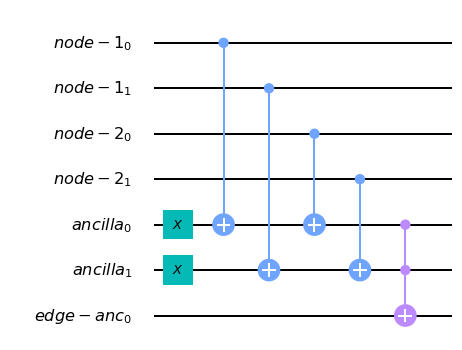

In [9]:
n1 = QuantumRegister(2, 'node-1')
n2 = QuantumRegister(2, 'node-2')
anc = QuantumRegister(2, 'ancilla')
er = QuantumRegister(1, 'edge-anc')
edge_check_circuit = QuantumCircuit(n1, n2, anc, er)

edge_check_circuit.x(anc)
edge_check_circuit.cx(n1[0], anc[0])
edge_check_circuit.cx(n2[0], anc[0])

edge_check_circuit.cx(n1[1], anc[1])
edge_check_circuit.cx(n2[1], anc[1])

edge_check_circuit.ccx(anc[0], anc[1], er[0])

edge_check_circuit.draw(output='mpl')

As we can see here that this check requires 4 cx and 1 ccx with total cost = 111 (without cleaning the two ancillas used back to $\left|00\right\rangle$)

#### Node Ancilla

As for node ancilla, we can achieve it by `x` and `ccx` gate. For example checking the node isn't in the state $\left|01\right\rangle$

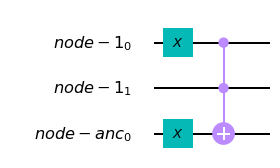

In [13]:
n1 = QuantumRegister(2, 'node-1')
na = QuantumRegister(1, 'node-anc')
node_anc_circuit = QuantumCircuit(n1, na)

node_anc_circuit.x(na)
node_anc_circuit.x(n1[0])
node_anc_circuit.ccx(n1[0], n1[1], na)


node_anc_circuit.draw(output='mpl')

<hr>

With the idea above, we'd need 13 edge ancillas and 7 node ancillas. But we can do it better by taking advantages of graph connectivity of the problem. Reducing the edge check means reducing the cost also. For example, node A, 0, 2, and 3 from a complete graph of size 4. By using this information we can conclude that valid assignment to the four nodes must xor to **00** or that the four must have **00, 01, 10, 11** exactly once.


<img src="../../problems/final/tokyo_map_pic.png" width="700">

### Reduce Check Contidions

1. node 2, 3, 5, and 6 form complete graph of size 4. **We have 4 ancilla bits to check that from this four nodes, 00, 01, 10, and 11 are presented or not.**
1. in the process of checking existence of 00, 01, 10, 11 from the four nodes, we also encode that 11(D) must be from 2 or 3 because 5, 6 are adjacent to D; 11(C) can't be from 2; 00(A) must be from 5 or 6; etc
1. node A, 0, 2, and 3 also form complete graph of size 4 so xor(0, 2, 3) must be equal to 00. **We have 1 ancilla bit to check this**. 
1. Since we already force 2 and 3 to not be equal to each other nor 00(A) we can safely assume that if ancilla bit from (3) and the four earlier from (1) can be only be in state $\left|1\right\rangle$ if the conditions are met.
1. Focusing on node 1; since node 2 is adjacent to C(10) we conclude that one of node 0 or 3 must be C(10) (from the complete graph argument), node 1 must be 00 or 11 only. **We have 1 ancilla bit to check whether node 1 is 00/11.**

From point 1, 3, and 5 we can reduce the edge check to only 4 edges namely 13, 14, 34, and 46.

In total we need 4 edge ancilla, 1 node ancilla (node 4), and 6 ancilla from this step. But still we could reduce the cost more by optimizing components of circuits used.

#### Complete Graph of Size 4 checking

We give the implementation of how we check node 2, 3, 5, 6 conditions below

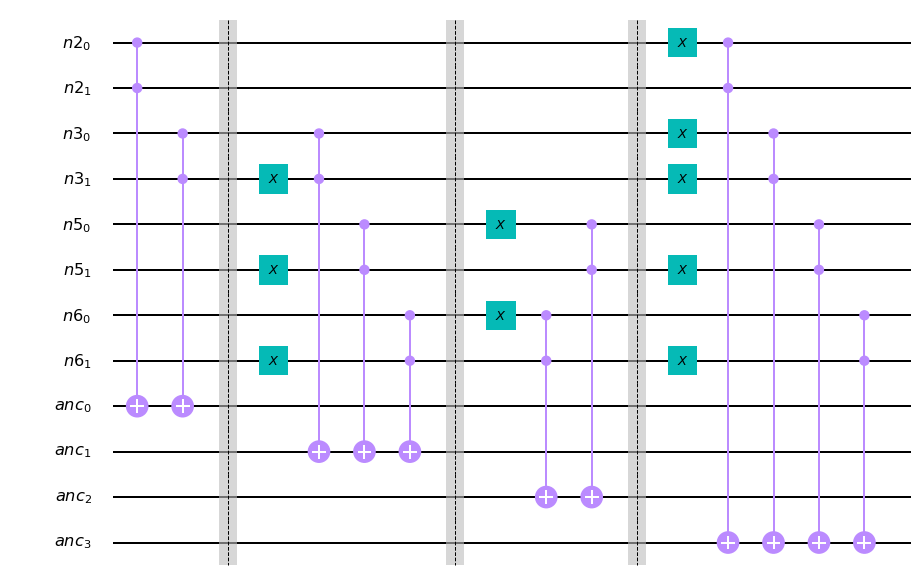

In [16]:
node2 = QuantumRegister(2, 'n2')
node3 = QuantumRegister(2, 'n3')
node5 = QuantumRegister(2, 'n5')
node6 = QuantumRegister(2, 'n6')
anc = QuantumRegister(4, 'anc')

qc = QuantumCircuit(node2, node3, node5, node6, anc)

dist = { 2: node2, 3: node3, 5: node5, 6:node6 }


gs = [2,3,5,6]
# D 11 / 11 11 11 11
for i in [2,3]:
    qc.ccx(dist[i][0], dist[i][1], anc[0])
qc.barrier()
# C 10 / 11 10 10 10
for i in [3,5,6]:
    qc.x(dist[i][1])
for i in [3,5,6]:
    qc.ccx(dist[i][0], dist[i][1], anc[1])
qc.barrier()
# A 00 / 11 10 00 00
for i in [5,6]:
    qc.x(dist[i][0])
for i in [6,5]:
    qc.ccx(dist[i][0], dist[i][1], anc[2])
qc.barrier()
# B 01 / 01 01 01 01
for i in [3,5,6]:
    qc.x(dist[i][1])
for i in [2,3]:
    qc.x(dist[i][0])
for i in gs:
    qc.ccx(dist[i][0], dist[i][1], anc[3])
    
qc.draw(output='mpl')

## Optimizing Circuit Part

`n_cnot` is the multi-controlled toffoli gate, implementing using the techniques from [arXiv:quant-ph/9503016](https://arxiv.org/abs/quant-ph/9503016)

We have free 7 ancilla bits to use and we can have other regs act as dirty ancilla bits when performing linear simulation of multi-control-toffoli. 

`hxh` to combine HXH into one U3 gate

`hx` and `xh` to combine HX and XH into one U3 gate to minimize cost on Grover's Diffusion part.

`ccm` simplified toffoli gate (margolus) gate / relative phase toffoli (in qiskit `rccx`) which can be used in place of `ccx` when performing task that will later reverse the operation (perfect for use with ancillary bits since we'll need to reset them back later)

In [18]:
def _n_cnot_inner(qc, ctrls, target, working_bits):
    n = len(ctrls)
    if len(working_bits) < n - 2:
        raise ValueError('working qubit is not enough, given {} bit need at least {} bit'.format(
            len(working_bits), n - 2))
    qs = [ctrls[i] for i in range(n)]
    qs = qs + [working_bits[i] for i in range(n - 2)]
    qs = qs + [target]
    qc.ccx(qs[n-1], qs[-2], qs[-1])
    for i in range(1, n - 2):
        qc.ccm(qs[n - 1 - i], qs[-2 - i], qs[-1 - i], end=False)
    qc.ccm(qs[0], qs[1], qs[n])
    for i in reversed(range(1, n - 2)):
        qc.ccm(qs[n - 1 - i], qs[-2 - i], qs[-1 - i], begin=False)
    qc.ccx(qs[n-1], qs[-2], qs[-1])
    for i in range(1, n - 2):
        qc.ccm(qs[n - 1 - i], qs[-2 - i], qs[-1 - i], end=False)
    qc.ccm(qs[0], qs[1], qs[n])
    for i in reversed(range(1, n - 2)):
        qc.ccm(qs[n - 1 - i], qs[-2 - i], qs[-1 - i], begin=False)


def n_cnot(self, ctrls, target, anc, dirty_ancilla=None, flags=None):
    
    if flags is not None:
        if len(flags) != len(ctrls):
            raise ValueError('flags len must be equal to ctrls len')

        for i in range(len(flags)):
            if flags[i] == -1:
                self.x(ctrls[i])
    
    if len(ctrls) == 1:
        self.cx(ctrls[0], target)
    elif len(ctrls) == 2:
        self.ccx(ctrls[0], ctrls[1], target)
    elif dirty_ancilla is not None:
        if len(dirty_ancilla) < len(ctrls) - 2:
            raise ValueError('dirty anc qubit is not enough, needed {} bit'.format(len(ctrls)-2))
        if len(ctrls) == 3 and anc is not None and len(anc) >= 1:
            self.ccm(ctrls[0], ctrls[1], anc[0])
            self.ccx(ctrls[2], anc[1], target)
            self.ccm(ctrls[0], ctrls[1], anc[0])
        elif len(ctrls) == 4 and len(anc) >= 2:
            self.ccm(ctrls[0], ctrls[1], anc[0])
            self.ccm(ctrls[2], ctrls[3], anc[1])
            self.ccx(anc[0], anc[1], target)
            self.ccm(ctrls[0], ctrls[1], anc[0])
            self.ccm(ctrls[2], ctrls[3], anc[1])
        else:
            print('ctrl len = {}'.format(len(ctrls)))
            if anc is not None:
                print('chotto matte, motto ii houhou ga aru yo!')
                print('anc len = {}'.format(len(anc)))
            else:
                print('no ancilla is given')
            _n_cnot_inner(self, ctrls, target, dirty_ancilla)
    else:
        if len(anc) < 1:
            raise ValueError(
                'ancillary qubit needs to be at least 1 bit, given {} bit'.format(len(anc)))
    
        n = len(ctrls) + 2
        m = int((n + 1) // 2)
        _anc = anc[0]
        _n_cnot_inner(self, ctrls[:m], _anc, ctrls[m:] + [target])
        _n_cnot_inner(self, ctrls[m:] + [_anc], target, ctrls[:m])
        _n_cnot_inner(self, ctrls[:m], _anc, ctrls[m:] + [target])
        _n_cnot_inner(self, ctrls[m:] + [_anc], target, ctrls[:m])

    if flags is not None:
        for i in range(len(flags)):
            if flags[i] == -1:
                self.x(ctrls[i])


def ccm(self, a, b, c, begin=True, end=True):
    if begin:
        self.ry(np.pi/4, c)
    self.cx(b, c)
    self.ry(np.pi/4, c)
    self.cx(a, c)
    self.ry(-np.pi/4, c)
    self.cx(b, c)
    if end:
        self.ry(-np.pi/4, c)
    self.barrier()
    
def hxh(self, a):
    self.u3(0.0, np.pi/2, np.pi/2, a)
    
def hx(self, a):
    self.u3(np.pi/2, 0.0, 0.0, a)
    
def xh(self, a):
    self.u3(np.pi/2, np.pi, -np.pi, a)
    
QuantumCircuit.n_cnot = n_cnot

QuantumCircuit.hxh = hxh
QuantumCircuit.xh = xh
QuantumCircuit.hx = hx
QuantumCircuit.ccm = ccm

So whenever possible, we can replace `ccx` with relative phase toffoli gate (implemented below) 

the cost goes down from 69 to 34.

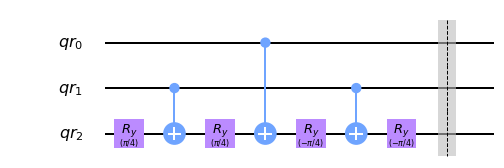

In [19]:
qr = QuantumRegister(3, 'qr')
qc = QuantumCircuit(qr)

qc.ccm(qr[0], qr[1], qr[2])
qc.draw(output='mpl')

## Putting  every pieces together

There are still more places to be optimised like 

- reusing ancilla bits (for edge checking)
- removing duplicate/unnecessary gates (when operate in pairs)
- where to change toffoli into relative phase toffoli

which can be seen in details in the block below for the real implementation of our solution.

<hr>

In [5]:
def Uf_graph(cities, edges, anc):
    qc = QuantumCircuit(cities, edges, anc)
    
    n = len(cities) // 2
    dist = [[cities[2 * i], cities[2 * i + 1]] for i in range(n)]
    e = {
        '13': edges[0],
        '14': edges[1],
        '34': edges[2],
        '46': edges[3]
    }
    
    def _eq(u, v, edge_str, oldU=False, oldV=False, keepU=False, keepV=False):
        nonlocal qc, cities, dist, e, edges, anc
        if not oldU:
            qc.cx(dist[u][0], anc[0])
            qc.cx(dist[u][1], anc[1])
        if not oldV:
            qc.cx(dist[v][0], anc[0])
            qc.cx(dist[v][1], anc[1])
        
        qc.ccm(anc[0], anc[1], e[edge_str])
        
        if not keepU:
            qc.cx(dist[u][0], anc[0])
            qc.cx(dist[u][1], anc[1])
        if not keepV:
            qc.cx(dist[v][0], anc[0])
            qc.cx(dist[v][1], anc[1]) 
        
    ## check edges
    qc.x([anc[0], anc[1]]) # flip anc[0],anc[1]
    # node 0, X
    _eq(3, 1, '13', keepV=True)
    _eq(4, 1, '14', oldV=True, keepU=True)
    _eq(4, 6, '46', oldU=True, keepU=True)
    _eq(4, 3, '34', oldU=True, keepV=True)
       
    # xor(0, 2, 3) must give 00 (3 is kept)
    ## bit-0
    qc.cx(dist[0][0], anc[0])
    qc.cx(dist[2][0], anc[0])
    ## bit-1
    qc.cx(dist[0][1], anc[1])
    qc.cx(dist[2][1], anc[1])
    ###
    qc.ccm(anc[0], anc[1], anc[4])
    ### reverse
    ## bit-0
    qc.cx(dist[0][0], anc[0])
    qc.cx(dist[2][0], anc[0])
    qc.cx(dist[3][0], anc[0])
    ## bit-1
    qc.cx(dist[0][1], anc[1])
    qc.cx(dist[2][1], anc[1])
    qc.cx(dist[3][1], anc[1])
    qc.x([anc[0], anc[1]]) # flip anc[0],anc[1]
    
    ## k4 on 2 3 5 6
    gs = [2,3,5,6]
    # D 11 / 11 11 11 11
    for i in [2,3]:
        qc.ccm(dist[i][0], dist[i][1], anc[0])
    # C 10 / 11 10 10 10
    for i in [3,5,6]:
        qc.x(dist[i][1])
    for i in [3,5,6]:
        qc.ccm(dist[i][0], dist[i][1], anc[1])
    # A 00 / 11 10 00 00
    for i in [5,6]:
        qc.x(dist[i][0])
    for i in [6,5]:
        qc.ccm(dist[i][0], dist[i][1], anc[2])
    # B 01 / 01 01 01 01
    for i in [3,5,6]:
        qc.x(dist[i][1])
    for i in [2,3]:
        qc.x(dist[i][0])
    for i in gs:
        qc.ccm(dist[i][0], dist[i][1], anc[3])
    
    
    ## condition for adj to assigned nodes
    # 4 B
    qc.x(anc[5])
    qc.x(dist[4][0])
    qc.ccm(dist[4][0], dist[4][1], anc[5])
    # 1 must be 00/11 only
    qc.x(anc[6])
    qc.cx(dist[1][0], anc[6])
    qc.cx(dist[1][1], anc[6])
    
    ## flip output if all edges[i] is 1
    # base anc
    qc.ccm(edges[0], edges[1], anc[7])
    qc.ccm(edges[2], edges[3], anc[8])
    qc.ccm(anc[0], anc[1], anc[9])
    qc.ccm(anc[2], anc[3], anc[10])
    qc.ccm(anc[4], anc[5], anc[11])
    # intermediate anc
    qc.ccm(anc[7], anc[8], anc[12])
    qc.ccm(anc[9], anc[10], anc[13])
    
    # flip if [anc[6], anc[11:14]] are 1
    qc.h(anc[6])
    qc.n_cnot(anc[11:14], anc[6], None, dirty_ancilla=cities)
    qc.h(anc[6])
    
    # intermediate anc
    qc.ccm(anc[9], anc[10], anc[13])
    qc.ccm(anc[7], anc[8], anc[12])
    # base anc
    qc.ccm(anc[4], anc[5], anc[11])
    qc.ccm(anc[2], anc[3], anc[10])
    qc.ccm(anc[0], anc[1], anc[9])
    qc.ccm(edges[2], edges[3], anc[8])
    qc.ccm(edges[0], edges[1], anc[7])
    
    ## condition for adj to assigned nodes (reverse order)
    # 1 must be 00/11 only
    qc.x(anc[6])
    qc.cx(dist[1][0], anc[6])
    qc.cx(dist[1][1], anc[6])
    # 4 B
    qc.ccm(dist[4][0], dist[4][1], anc[5])
    qc.x(dist[4][0])
    qc.x(anc[5])
    
    ## k4 on 2 3 5 6 (reverse order)
    gs = [2,3,5,6]
    # B 01 / 01 01 01 01
    for i in reversed(gs):
        qc.ccm(dist[i][0], dist[i][1], anc[3])
    for i in [3,5,6]:
        qc.x(dist[i][1])
    for i in [2,3]:
        qc.x(dist[i][0])
    # A 00 / 11 10 00 00
    for i in reversed([6,5]):
        qc.ccm(dist[i][0], dist[i][1], anc[2])
    for i in [5,6]:
        qc.x(dist[i][0])
    # C 10 / 11 10 10 10
    for i in reversed([3,5,6]):
        qc.ccm(dist[i][0], dist[i][1], anc[1])
    for i in [3,5,6]:
        qc.x(dist[i][1])
    # D 11 / 11 11 11 11
    for i in reversed([2,3]):
        qc.ccm(dist[i][0], dist[i][1], anc[0])
    
    ## check edges
    qc.x([anc[0], anc[1]]) # flip anc[0],anc[1]
    # node 0, X
    _eq(3, 1, '13', keepV=True)
    _eq(4, 1, '14', oldV=True, keepU=True)
    _eq(4, 6, '46', oldU=True, keepU=True)
    _eq(4, 3, '34', oldU=True, keepV=True)
       
    # xor(0, 2, 3) must give 00 (3 is kept)
    ## bit-0
    qc.cx(dist[0][0], anc[0])
    qc.cx(dist[2][0], anc[0])
    ## bit-1
    qc.cx(dist[0][1], anc[1])
    qc.cx(dist[2][1], anc[1])
    ###
    qc.ccm(anc[0], anc[1], anc[4])
    ### reverse
    ## bit-0
    qc.cx(dist[0][0], anc[0])
    qc.cx(dist[2][0], anc[0])
    qc.cx(dist[3][0], anc[0])
    ## bit-1
    qc.cx(dist[0][1], anc[1])
    qc.cx(dist[2][1], anc[1])
    qc.cx(dist[3][1], anc[1])
    qc.x([anc[0], anc[1]]) # flip anc[0],anc[1]
    
    
    return qc

In [6]:
def grover_init(cities, edges, anc):
    qc = QuantumCircuit(cities, edges, anc)
    qc.h(cities)
    qc.x(edges)
    qc.barrier()
    return qc

In [7]:
def grover_diffusion(ipt, _anc, edges, dirty_ancilla):
    
    if dirty_ancilla is not None:
        qc = QuantumCircuit(ipt, _anc, edges, dirty_ancilla)
    else:
        qc = QuantumCircuit(ipt, _anc, edges)
    
    anc = _anc[:] + edges[:]
    
    n = len(ipt)
    anc_n = len(_anc)
    
    qc.hx(ipt[:-1])
    qc.hxh(ipt[-1])
    
    if anc_n < n-3:
        qc.x(anc[anc_n:n-3])
    qc.ccm(ipt[0], ipt[1], anc[0])
    for i in range(2, n-2):
        qc.ccm(ipt[i], anc[i-2], anc[i-1])
    qc.ccx(ipt[-2], anc[n-4], ipt[-1])
    for i in reversed(range(2, n-2)):
        qc.ccm(ipt[i], anc[i-2], anc[i-1])
    qc.ccm(ipt[0], ipt[1], anc[0])
    if anc_n < n-3:
        qc.x(anc[anc_n:n-3])

    qc.hxh(ipt[-1])
    qc.xh(ipt[:-1])

    return qc

In [8]:
def measurement(ipt, c_output):
    qc = QuantumCircuit(ipt, c_output)
    qc.measure(ipt, c_output)
    return qc   

## Now onto the whole algorithm circuit part

In [9]:
cities = QuantumRegister(14, 'cities')
edges = QuantumRegister(4, 'edges')
anc = QuantumRegister(14, 'anc')
c_out = ClassicalRegister(14, 'c_out')
job_id = ''

_qc_init = grover_init(cities, edges, anc)
_Uf_graph = Uf_graph(cities, edges, anc)
_diffusion = grover_diffusion(cities, anc, edges, None)
_empty_qc = QuantumCircuit(cities, edges, anc)
_measurement = measurement(cities, c_out)

qc = _qc_init + _empty_qc
for i in range(5):
    qc = qc + _Uf_graph + _diffusion
    
qc.barrier()
qc = qc + _measurement

ctrl len = 3
no ancilla is given


## Submit Job to Cloud Simulator

In [11]:
backend = provider.get_backend('ibmq_qasm_simulator')
job = qiskit.execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})

print(job.job_id())
job_id = job.job_id()

now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print('job is initiated at {}'.format(dt_string))

filename='./submitted_jobs.txt'
with open(filename, 'a+') as f:
    f.write('{} - {}\n'.format(dt_string, job_id))

5da40e7fecbd6d0018d9a8e1
job is initiated at 14/10/2019 12:58:28


In [13]:
# job = backend.retrieve_job('5da12f8a2580ab0018a4713a')
result = job.result()
count = result.get_counts()
# print(count)
#`shots` are set to 8000 to increase sampling
#`seed_simulator`` is set to 12345 to 'lock' its value, and 
#`backend_options={"fusion_enable":True}` is specified to improve simulator performance.

## Submission part

In [14]:
# Input your quantum circuit
circuit = qc

# Input your result of the execute(groverCircuit, backend=backend, shots=shots).result()

results = result
# results = backend.retrieve_job(job_id).result()

count = results.get_counts()

# Provide your team name
name='Whit3z'

# Please indicate the number of times you have made a submission so far. 
# For example, if it's your 1st time to submit your answer, write 1. If it's your 5th time to submit your answer, write 5.
times='15'

In [15]:
# Unroll the circuit
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(circuit) 

# obtain gates
gates=new_circuit.count_ops()

#sort count
count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

# collect answers with Top 9 probability
ans_list = count_sorted[0:20]

# reverse ans_list
ans_reversed = []
for i in ans_list:
    ans_temp=[i[0][::-1],i[1]]
    ans_reversed.append(ans_temp)

# convert each 2 bits into corresponding color. Add node0(0),node3(1),node8(2) and node11(3)
ans_shaped = []
for j in ans_reversed:
    ans_temp=j[0]
    nodeA = 0
    node0 = int(ans_temp[0] + ans_temp[1], 2)
    node1 = int(ans_temp[2] + ans_temp[3], 2)
    nodeB = 1
    node2 = int(ans_temp[4] + ans_temp[5], 2)
    node3 = int(ans_temp[6] + ans_temp[7], 2)
    node4 = int(ans_temp[8] + ans_temp[9], 2)
    nodeC = 2
    node5 = int(ans_temp[10] + ans_temp[11], 2)
    node6 = int(ans_temp[12] + ans_temp[13], 2)
    nodeD = 3
    nodes_color = str(nodeA) + str(node0) + str(node1) + str(nodeB) + str(node2) + str(node3) + str(node4) + str(nodeC) + str(node5) + str(node6) + str(nodeD) 
    ans_shaped.append([nodes_color,j[1]])

# write the result into '[your name]_final_output.txt'
filename='./output/'+name+'_'+times+'_final_output.txt'
dct={'ans':ans_shaped,'costs':gates}
with open(filename, 'w') as f:
    json.dump(dct, f)

## Verification Program

In [21]:
def solution_checker(ans):
    for a in ans:
        s = a[0]
        s = s[1:3] + s[4:7] + s[8:10]
        correct = True
        
        # check node 0 1 2 3 4 5 6
        correct = correct and (s[0] != '0')
        correct = correct and (s[1] != '1')
        correct = correct and (s[2] != '0')
        correct = correct and (s[2] != '2')
        correct = correct and (s[3] != '0')
        correct = correct and (s[4] != '1')
        correct = correct and (s[5] != '3')
        correct = correct and (s[6] != '3')

        # check edges
        correct = correct and (s[0] != s[1])
        correct = correct and (s[0] != s[2])
        correct = correct and (s[0] != s[3])
        correct = correct and (s[1] != s[3])
        correct = correct and (s[1] != s[4])
        correct = correct and (s[2] != s[3])
        correct = correct and (s[2] != s[5])
        correct = correct and (s[2] != s[6])
        correct = correct and (s[3] != s[4])
        correct = correct and (s[3] != s[5])
        correct = correct and (s[3] != s[6])
        correct = correct and (s[4] != s[6])
        correct = correct and (s[5] != s[6])
        
        if not correct:
            print('wrong answer on: {} with count {}'.format(a[0], a[1]))
        else:
            print('Yay! {} is one of the solutions with count {}'.format(a[0], a[1]))

In [22]:
# Input the path of your submission file
your_path='./output/Whit3z_{}_final_output.txt'.format(times)

p= Path(your_path)

# Verify your information
f_name=p.name
your_info=f_name.split('_')
print('Your name: ', your_info[0])
print('The number of times you have submitted your answer: ', your_info[1])

with open(p, 'r') as f:
    print(f)
    your_ans=json.load(f)

solution_checker(your_ans['ans'])
    
print('Does your submission file have 9 answers?')
if (len(your_ans['ans'])!=9):
    print('- No, make sure you have 9 answers with top 9 probabilities')
else:
    
    print('- Yes')
    print('- Your plan: ', your_ans['ans'])

print('What is your cost?')
your_cost=your_ans['costs']['u3'] + 10*your_ans['costs']['cx']
print(your_cost)

Your name:  Whit3z
The number of times you have submitted your answer:  15
<_io.TextIOWrapper name='output/Whit3z_15_final_output.txt' mode='r' encoding='UTF-8'>
Yay! 01013232103 is one of the solutions with count 66
Yay! 02013132023 is one of the solutions with count 62
Yay! 02011322203 is one of the solutions with count 61
Yay! 01013232013 is one of the solutions with count 53
Yay! 02013132203 is one of the solutions with count 52
Yay! 02313102023 is one of the solutions with count 51
Yay! 02313122203 is one of the solutions with count 49
Yay! 02013122203 is one of the solutions with count 48
Yay! 01313202013 is one of the solutions with count 48
Does your submission file have 9 answers?
- Yes
- Your plan:  [['01013232103', 66], ['02013132023', 62], ['02011322203', 61], ['01013232013', 53], ['02013132203', 52], ['02313102023', 51], ['02313122203', 49], ['02013122203', 48], ['01313202013', 48]]
What is your cost?
16613
